# Aggregation of the parcels of the different atlas

## Automatic aggregation (K-means, Spectral Clustering, Hierarchical Clustering)

In [113]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import nilearn
import pydicom as dicom
import torch

from tqdm.notebook import tqdm

In [114]:
## FUNCTION TO SAVE DATA IN RIGHT FORMAT FOR xGW-GAT ##

DATA_FOLDER = './comparison_data/ABIDE/'

def save_data(DATA_FOLDER, correlation_matrices, scores):
    try:
        conn = torch.Tensor(correlation_matrices)
        print(f"Connectome (X) shape: {conn.shape}") # n_ROIs, n_ROIs, n_subjects

        scores = torch.LongTensor(scores)
        print(f"Gait scores (y) shape: {scores.shape}") # n_subjects
        torch.save(conn, f"{DATA_FOLDER}/connectomes_0.npy")
        torch.save(scores, f"{DATA_FOLDER}/scores.npy")

        merged_df_multi = pd.DataFrame(list(zip(correlation_matrices, scores, [i for i in range(len(scores))])),
                columns =['corr', 'labels', 'p_ids'])
        records_multi = merged_df_multi.to_records(index=False)
        data_multi = np.array(records_multi, dtype=records_multi.dtype.descr)
        np.save(f"{DATA_FOLDER}/ppmi_multi.npy", data_multi)
        print("Data saved successfully!")
        return True
    except Exception as e:
        print("Error saving data: ", e)
        return False


In [115]:
# Load the .npy files for the ABIDE dataset
data_aal = np.load('./data_abide_aal/ABIDE_pcp/abide.npy', allow_pickle=True).item()

In [116]:
data_aal["corr"].shape

(1009, 116, 116)

In [117]:
# check if data_aal["corr"] has nans 
print(np.isnan(data_aal["corr"]).any())
# check if data_aal["corr"] has infs
print(np.isinf(data_aal["corr"]).any())

False
False


In [118]:
from sklearn.cluster import KMeans, SpectralClustering
from scipy.cluster.hierarchy import linkage, fcluster

def aggregate_matrices(data, n_clusters, method='kmeans'):
    """
    Applies clustering to each subject's correlation matrix and aggregates 
    these into a smaller matrix.

    :param data: 3D numpy array, shape (subjects, nodes, nodes)
    :param n_clusters: int, the number of clusters for aggregation
    :param method: str, 'kmeans', 'spectral', or 'hierarchical' for the clustering method
    :return: 2D numpy array, aggregated matrix
    """
    n_subjects = data.shape[0]
    store = np.zeros((n_subjects, n_clusters, n_clusters))

    for subject in tqdm(range(n_subjects)):
        corr_matrix = data[subject]

        # Apply the chosen clustering method
        if method == 'kmeans':
            flattened_data = corr_matrix.reshape((corr_matrix.shape[0], -1))
            model = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
            labels = model.fit_predict(flattened_data)
        elif method == 'spectral':
            model = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0)
            labels = model.fit_predict(corr_matrix)
        elif method == 'hierarchical':
            Z = linkage(corr_matrix, method='average')
            labels = fcluster(Z, n_clusters, criterion='maxclust')
        else:
            raise ValueError("Invalid method. Choose 'kmeans', 'spectral', or 'hierarchical'.")

        # Aggregate the correlations for each subject
        for i in range(n_clusters):
            for j in range(n_clusters):
                indices_i = np.where(labels == i)[0]
                indices_j = np.where(labels == j)[0]
                avg_correlation = np.mean([corr_matrix[x, y] for x in indices_i for y in indices_j])
                store[subject, i, j] = avg_correlation

    return store


In [119]:
agg_data = aggregate_matrices(data_aal["corr"], 20, 'kmeans')

print(agg_data.shape)

# Count number of nans in the matrices
n_nan = 0
for i in range(agg_data.shape[0]):
    for j in range(agg_data.shape[1]):
        for k in range(agg_data.shape[2]):
            if np.isnan(agg_data[i, j, k]):
                n_nan += 1
print(n_nan)


  0%|          | 0/1009 [00:00<?, ?it/s]

(1009, 20, 20)
0


In [122]:
data_aal.keys()

dict_keys(['timeseires', 'label', 'corr', 'pcorr', 'site', 'id'])

In [123]:
# Save data 
DATA_FOLDER_AGG = './comparison_data/ABIDE/automatic/'
save_data(DATA_FOLDER_AGG, agg_data, data_aal["label"])

Connectome (X) shape: torch.Size([1009, 20, 20])
Gait scores (y) shape: torch.Size([1009])
Data saved successfully!


True

### Manual aggregation of known regions using NiLearn

In [124]:
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker

dataset = datasets.fetch_atlas_aal(version='SPM12')
atlas_filename = dataset.maps
labels = dataset.labels
print('Length of labels:', len(labels))

Length of labels: 116


In [125]:
labels

['Precentral_L',
 'Precentral_R',
 'Frontal_Sup_L',
 'Frontal_Sup_R',
 'Frontal_Sup_Orb_L',
 'Frontal_Sup_Orb_R',
 'Frontal_Mid_L',
 'Frontal_Mid_R',
 'Frontal_Mid_Orb_L',
 'Frontal_Mid_Orb_R',
 'Frontal_Inf_Oper_L',
 'Frontal_Inf_Oper_R',
 'Frontal_Inf_Tri_L',
 'Frontal_Inf_Tri_R',
 'Frontal_Inf_Orb_L',
 'Frontal_Inf_Orb_R',
 'Rolandic_Oper_L',
 'Rolandic_Oper_R',
 'Supp_Motor_Area_L',
 'Supp_Motor_Area_R',
 'Olfactory_L',
 'Olfactory_R',
 'Frontal_Sup_Medial_L',
 'Frontal_Sup_Medial_R',
 'Frontal_Med_Orb_L',
 'Frontal_Med_Orb_R',
 'Rectus_L',
 'Rectus_R',
 'Insula_L',
 'Insula_R',
 'Cingulum_Ant_L',
 'Cingulum_Ant_R',
 'Cingulum_Mid_L',
 'Cingulum_Mid_R',
 'Cingulum_Post_L',
 'Cingulum_Post_R',
 'Hippocampus_L',
 'Hippocampus_R',
 'ParaHippocampal_L',
 'ParaHippocampal_R',
 'Amygdala_L',
 'Amygdala_R',
 'Calcarine_L',
 'Calcarine_R',
 'Cuneus_L',
 'Cuneus_R',
 'Lingual_L',
 'Lingual_R',
 'Occipital_Sup_L',
 'Occipital_Sup_R',
 'Occipital_Mid_L',
 'Occipital_Mid_R',
 'Occipital_Inf_L'

In [126]:
# Aggregate the corr matrices in data_all according to the brain_region_groups

def aggregate_matrices_manual(data, groups_dict):
    """
    Applies clustering to each subject's correlation matrix and aggregates 
    these into a smaller matrix.

    :param data: 3D numpy array, shape (subjects, nodes, nodes)
    :param groups_dict: dictionary, keys are names of brain regions, values are lists of node indices
    :return: 2D numpy array, aggregated matrix
    """
    n_subjects = data.shape[0]
    n_regions = len(groups_dict)
    store = np.zeros((n_subjects, n_regions, n_regions))

    for subject in tqdm(range(n_subjects)):
        corr_matrix = data[subject]

        # Aggregate the correlations for each subject
        for i, region_i in enumerate(groups_dict.keys()):
            for j, region_j in enumerate(groups_dict.keys()):
                indices_i = groups_dict[region_i]
                indices_j = groups_dict[region_j]
                indices_i = [labels.index(x) for x in indices_i]
                indices_j = [labels.index(x) for x in indices_j]
                avg_correlation = np.mean([corr_matrix[x, y] for x in indices_i for y in indices_j])
                store[subject, i, j] = avg_correlation

    return store

#### Coarse-grained 7 groups

In [127]:
brain_region_groups = {
    "Frontal Lobe Regions": [
        "Precentral_L", "Precentral_R",
        "Frontal_Sup_L", "Frontal_Sup_R",
        "Frontal_Sup_Orb_L", "Frontal_Sup_Orb_R",
        "Frontal_Mid_L", "Frontal_Mid_R",
        "Frontal_Mid_Orb_L", "Frontal_Mid_Orb_R",
        "Frontal_Inf_Oper_L", "Frontal_Inf_Oper_R",
        "Frontal_Inf_Tri_L", "Frontal_Inf_Tri_R",
        "Frontal_Inf_Orb_L", "Frontal_Inf_Orb_R",
        "Rolandic_Oper_L", "Rolandic_Oper_R",
        "Supp_Motor_Area_L", "Supp_Motor_Area_R",
        "Olfactory_L", "Olfactory_R",
        "Frontal_Sup_Medial_L", "Frontal_Sup_Medial_R",
        "Frontal_Med_Orb_L", "Frontal_Med_Orb_R",
        "Rectus_L", "Rectus_R"
    ],
    "Parietal Lobe Regions": [
        "Postcentral_L", "Postcentral_R",
        "Parietal_Sup_L", "Parietal_Sup_R",
        "Parietal_Inf_L", "Parietal_Inf_R",
        "SupraMarginal_L", "SupraMarginal_R",
        "Angular_L", "Angular_R",
        "Precuneus_L", "Precuneus_R",
        "Paracentral_Lobule_L", "Paracentral_Lobule_R"
    ],
    "Temporal Lobe Regions": [
        "Heschl_L", "Heschl_R",
        "Temporal_Sup_L", "Temporal_Sup_R",
        "Temporal_Pole_Sup_L", "Temporal_Pole_Sup_R",
        "Temporal_Mid_L", "Temporal_Mid_R",
        "Temporal_Pole_Mid_L", "Temporal_Pole_Mid_R",
        "Temporal_Inf_L", "Temporal_Inf_R"
    ],
    "Occipital Lobe Regions": [
        "Calcarine_L", "Calcarine_R",
        "Cuneus_L", "Cuneus_R",
        "Lingual_L", "Lingual_R",
        "Occipital_Sup_L", "Occipital_Sup_R",
        "Occipital_Mid_L", "Occipital_Mid_R",
        "Occipital_Inf_L", "Occipital_Inf_R",
        "Fusiform_L", "Fusiform_R"
    ],
    "Limbic Lobe Regions": [
        "Insula_L", "Insula_R",
        "Cingulum_Ant_L", "Cingulum_Ant_R",
        "Cingulum_Mid_L", "Cingulum_Mid_R",
        "Cingulum_Post_L", "Cingulum_Post_R",
        "Hippocampus_L", "Hippocampus_R",
        "ParaHippocampal_L", "ParaHippocampal_R",
        "Amygdala_L", "Amygdala_R"
    ],
    "Subcortical Structures": [
        "Caudate_L", "Caudate_R",
        "Putamen_L", "Putamen_R",
        "Pallidum_L", "Pallidum_R",
        "Thalamus_L", "Thalamus_R"
    ],
    "Cerebellar Regions": [
        "Cerebelum_Crus1_L", "Cerebelum_Crus1_R",
        "Cerebelum_Crus2_L", "Cerebelum_Crus2_R",
        "Cerebelum_3_L", "Cerebelum_3_R",
        "Cerebelum_4_5_L", "Cerebelum_4_5_R",
        "Cerebelum_6_L", "Cerebelum_6_R",
        "Cerebelum_7b_L", "Cerebelum_7b_R",
        "Cerebelum_8_L", "Cerebelum_8_R",
        "Cerebelum_9_L", "Cerebelum_9_R",
        "Cerebelum_10_L", "Cerebelum_10_R",
        "Vermis_1_2", "Vermis_3", "Vermis_4_5",
        "Vermis_6", "Vermis_7", "Vermis_8",
        "Vermis_9", "Vermis_10"
    ]
}


In [128]:
# Test the function
agg_data_manual = aggregate_matrices_manual(data_aal["corr"], brain_region_groups)

print(agg_data_manual.shape)

# Count number of nans in the matrices
n_nan = 0
for i in range(agg_data_manual.shape[0]):
    for j in range(agg_data_manual.shape[1]):
        for k in range(agg_data_manual.shape[2]):
            if np.isnan(agg_data_manual[i, j, k]):
                n_nan += 1
print(n_nan)

  0%|          | 0/1009 [00:00<?, ?it/s]

(1009, 7, 7)
0


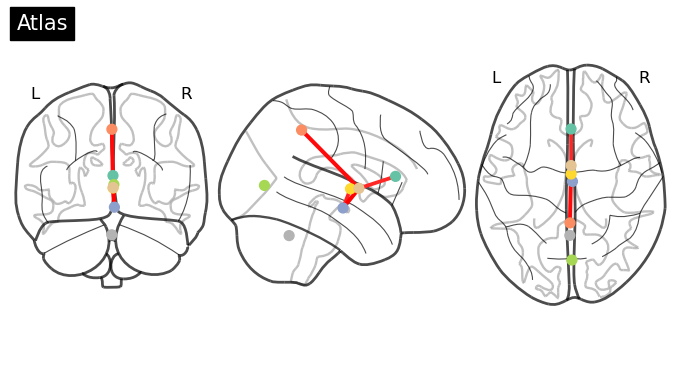

In [129]:
from nilearn import plotting

# Plot of the cortical atlas with connectome 
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)


# Get center of coordinates according to the brain_region_groups
coordinates_avg = []
for region in brain_region_groups.keys():
    indices = [labels.index(x) for x in brain_region_groups[region]]
    # take mean for each dimension
    avg_coord = np.mean(coordinates[indices, :], axis=0)
    coordinates_avg.append(avg_coord)


plotting.plot_connectome(
    agg_data_manual[0],
    coordinates_avg,
    edge_threshold="80%",
    title="Atlas",
)

In [130]:
# Save data 
DATA_FOLDER_AGG = './comparison_data/ABIDE/manual/'
save_data(DATA_FOLDER_AGG, agg_data_manual, data_aal["label"])

Connectome (X) shape: torch.Size([1009, 7, 7])
Gait scores (y) shape: torch.Size([1009])
Data saved successfully!


True

#### Distinguishing the groups for L/R hemispheres --> 15 groups 

In [131]:
brain_region_groups = {
    "Frontal Lobe Regions - Left": [
        "Precentral_L",
        "Frontal_Sup_L",
        "Frontal_Sup_Orb_L",
        "Frontal_Mid_L",
        "Frontal_Mid_Orb_L",
        "Frontal_Inf_Oper_L",
        "Frontal_Inf_Tri_L",
        "Frontal_Inf_Orb_L",
        "Rolandic_Oper_L",
        "Supp_Motor_Area_L",
        "Olfactory_L",
        "Frontal_Sup_Medial_L",
        "Frontal_Med_Orb_L",
        "Rectus_L"
    ],
    "Frontal Lobe Regions - Right": [
        "Precentral_R",
        "Frontal_Sup_R",
        "Frontal_Sup_Orb_R",
        "Frontal_Mid_R",
        "Frontal_Mid_Orb_R",
        "Frontal_Inf_Oper_R",
        "Frontal_Inf_Tri_R",
        "Frontal_Inf_Orb_R",
        "Rolandic_Oper_R",
        "Supp_Motor_Area_R",
        "Olfactory_R",
        "Frontal_Sup_Medial_R",
        "Frontal_Med_Orb_R",
        "Rectus_R"
    ],
    "Parietal Lobe Regions - Left": [
        "Postcentral_L",
        "Parietal_Sup_L",
        "Parietal_Inf_L",
        "SupraMarginal_L",
        "Angular_L",
        "Precuneus_L",
        "Paracentral_Lobule_L"
    ],
    "Parietal Lobe Regions - Right": [
        "Postcentral_R",
        "Parietal_Sup_R",
        "Parietal_Inf_R",
        "SupraMarginal_R",
        "Angular_R",
        "Precuneus_R",
        "Paracentral_Lobule_R"
    ],
    "Temporal Lobe Regions - Left": [
        "Heschl_L",
        "Temporal_Sup_L",
        "Temporal_Pole_Sup_L",
        "Temporal_Mid_L",
        "Temporal_Pole_Mid_L",
        "Temporal_Inf_L"
    ],
    "Temporal Lobe Regions - Right": [
        "Heschl_R",
        "Temporal_Sup_R",
        "Temporal_Pole_Sup_R",
        "Temporal_Mid_R",
        "Temporal_Pole_Mid_R",
        "Temporal_Inf_R"
    ],
    "Occipital Lobe Regions - Left": [
        "Calcarine_L",
        "Cuneus_L",
        "Lingual_L",
        "Occipital_Sup_L",
        "Occipital_Mid_L",
        "Occipital_Inf_L",
        "Fusiform_L"
    ],
    "Occipital Lobe Regions - Right": [
        "Calcarine_R",
        "Cuneus_R",
        "Lingual_R",
        "Occipital_Sup_R",
        "Occipital_Mid_R",
        "Occipital_Inf_R",
        "Fusiform_R"
    ],
    "Limbic Lobe Regions - Left": [
        "Insula_L",
        "Cingulum_Ant_L",
        "Cingulum_Mid_L",
        "Cingulum_Post_L",
        "Hippocampus_L",
        "ParaHippocampal_L",
        "Amygdala_L"
    ],
    "Limbic Lobe Regions - Right": [
        "Insula_R",
        "Cingulum_Ant_R",
        "Cingulum_Mid_R",
        "Cingulum_Post_R",
        "Hippocampus_R",
        "ParaHippocampal_R",
        "Amygdala_R"
    ],
    "Subcortical Structures - Left": [
        "Caudate_L",
        "Putamen_L",
        "Pallidum_L",
        "Thalamus_L"
    ],
    "Subcortical Structures - Right": [
        "Caudate_R",
        "Putamen_R",
        "Pallidum_R",
        "Thalamus_R"
    ],
    "Cerebellar Regions - Left": [
        "Cerebelum_Crus1_L",
        "Cerebelum_Crus2_L",
        "Cerebelum_3_L",
        "Cerebelum_4_5_L",
        "Cerebelum_6_L",
        "Cerebelum_7b_L",
        "Cerebelum_8_L",
        "Cerebelum_9_L",
        "Cerebelum_10_L"
    ],
    "Cerebellar Regions - Right": [
        "Cerebelum_Crus1_R",
        "Cerebelum_Crus2_R",
        "Cerebelum_3_R",
        "Cerebelum_4_5_R",
        "Cerebelum_6_R",
        "Cerebelum_7b_R",
        "Cerebelum_8_R",
        "Cerebelum_9_R",
        "Cerebelum_10_R"
    ],
    "Vermis Regions": [
        "Vermis_1_2",
        "Vermis_3",
        "Vermis_4_5",
        "Vermis_6",
        "Vermis_7",
        "Vermis_8",
        "Vermis_9",
        "Vermis_10"
    ]
}

In [132]:
# Test the function
agg_data_manual = aggregate_matrices_manual(data_aal["corr"], brain_region_groups)

print(agg_data_manual.shape)

# Count number of nans in the matrices
n_nan = 0
for i in range(agg_data_manual.shape[0]):
    for j in range(agg_data_manual.shape[1]):
        for k in range(agg_data_manual.shape[2]):
            if np.isnan(agg_data_manual[i, j, k]):
                n_nan += 1
print(n_nan)

  0%|          | 0/1009 [00:00<?, ?it/s]

(1009, 15, 15)
0


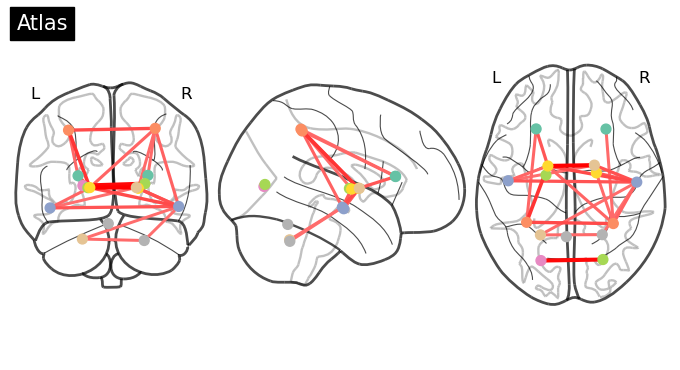

In [133]:
from nilearn import plotting

# Plot of the cortical atlas with connectome 
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)


# Get center of coordinates according to the brain_region_groups
coordinates_avg = []
for region in brain_region_groups.keys():
    indices = [labels.index(x) for x in brain_region_groups[region]]
    # take mean for each dimension
    avg_coord = np.mean(coordinates[indices, :], axis=0)
    coordinates_avg.append(avg_coord)


plotting.plot_connectome(
    agg_data_manual[0],
    coordinates_avg,
    edge_threshold="80%",
    title="Atlas",
)

In [134]:
# Save data 
DATA_FOLDER_AGG = './comparison_data/ABIDE/manual/'
save_data(DATA_FOLDER_AGG, agg_data_manual, data_aal["label"])

Connectome (X) shape: torch.Size([1009, 15, 15])
Gait scores (y) shape: torch.Size([1009])
Data saved successfully!


True

#### Fine-grained 17 groups

In [93]:
brain_region_groups = {
    "Frontal Lobe - Superior Regions": [
        "Frontal_Sup_L", "Frontal_Sup_R",
        "Frontal_Sup_Orb_L", "Frontal_Sup_Orb_R",
        "Frontal_Sup_Medial_L", "Frontal_Sup_Medial_R"
    ],
    "Frontal Lobe - Middle Regions": [
        "Frontal_Mid_L", "Frontal_Mid_R",
        "Frontal_Mid_Orb_L", "Frontal_Mid_Orb_R",
        "Frontal_Med_Orb_L", "Frontal_Med_Orb_R"
    ],
    "Frontal Lobe - Inferior Regions": [
        "Frontal_Inf_Oper_L", "Frontal_Inf_Oper_R",
        "Frontal_Inf_Tri_L", "Frontal_Inf_Tri_R",
        "Frontal_Inf_Orb_L", "Frontal_Inf_Orb_R"
    ],
    "Precentral and Motor Areas": [
        "Precentral_L", "Precentral_R",
        "Rolandic_Oper_L", "Rolandic_Oper_R",
        "Supp_Motor_Area_L", "Supp_Motor_Area_R"
    ],
    "Olfactory and Rectus Regions": [
        "Olfactory_L", "Olfactory_R",
        "Rectus_L", "Rectus_R"
    ],
    "Parietal Lobe - Superior Regions": [
        "Parietal_Sup_L", "Parietal_Sup_R",
        "Precuneus_L", "Precuneus_R"
    ],
    "Parietal Lobe - Inferior Regions": [
        "Parietal_Inf_L", "Parietal_Inf_R",
        "SupraMarginal_L", "SupraMarginal_R",
        "Angular_L", "Angular_R"
    ],
    "Postcentral and Paracentral Regions": [
        "Postcentral_L", "Postcentral_R",
        "Paracentral_Lobule_L", "Paracentral_Lobule_R"
    ],
    "Temporal Lobe - Superior Regions": [
        "Temporal_Sup_L", "Temporal_Sup_R",
        "Temporal_Pole_Sup_L", "Temporal_Pole_Sup_R"
    ],
    "Temporal Lobe - Middle Regions": [
        "Temporal_Mid_L", "Temporal_Mid_R",
        "Temporal_Pole_Mid_L", "Temporal_Pole_Mid_R"
    ],
    "Temporal Lobe - Inferior Regions": [
        "Temporal_Inf_L", "Temporal_Inf_R",
        "Heschl_L", "Heschl_R"
    ],
    "Occipital Lobe Regions": [
        "Calcarine_L", "Calcarine_R",
        "Cuneus_L", "Cuneus_R",
        "Lingual_L", "Lingual_R",
        "Occipital_Sup_L", "Occipital_Sup_R",
        "Occipital_Mid_L", "Occipital_Mid_R",
        "Occipital_Inf_L", "Occipital_Inf_R"
    ],
    "Fusiform and Insular Regions": [
        "Fusiform_L", "Fusiform_R",
        "Insula_L", "Insula_R"
    ],
    "Limbic Lobe Regions": [
        "Cingulum_Ant_L", "Cingulum_Ant_R",
        "Cingulum_Mid_L", "Cingulum_Mid_R",
        "Cingulum_Post_L", "Cingulum_Post_R",
        "Hippocampus_L", "Hippocampus_R",
        "ParaHippocampal_L", "ParaHippocampal_R",
        "Amygdala_L", "Amygdala_R"
    ],
    "Subcortical Nuclei": [
        "Caudate_L", "Caudate_R",
        "Putamen_L", "Putamen_R",
        "Pallidum_L", "Pallidum_R",
        "Thalamus_L", "Thalamus_R"
    ],
    "Cerebellar Hemispheres": [
        "Cerebelum_Crus1_L", "Cerebelum_Crus1_R",
        "Cerebelum_Crus2_L", "Cerebelum_Crus2_R",
        "Cerebelum_3_L", "Cerebelum_3_R",
        "Cerebelum_4_5_L", "Cerebelum_4_5_R",
        "Cerebelum_6_L", "Cerebelum_6_R",
        "Cerebelum_7b_L", "Cerebelum_7b_R",
        "Cerebelum_8_L", "Cerebelum_8_R",
        "Cerebelum_9_L", "Cerebelum_9_R",
        "Cerebelum_10_L", "Cerebelum_10_R"
    ],
    "Cerebellar Vermis Regions":[
        "Vermis_1_2", "Vermis_3", 
        "Vermis_4_5", "Vermis_6", 
        "Vermis_7", "Vermis_8", 
        "Vermis_9", "Vermis_10"
    ]
}

In [94]:
# Test the function
agg_data_manual = aggregate_matrices_manual(data_aal["corr"], brain_region_groups)

print(agg_data_manual.shape)

# Count number of nans in the matrices
n_nan = 0
for i in range(agg_data_manual.shape[0]):
    for j in range(agg_data_manual.shape[1]):
        for k in range(agg_data_manual.shape[2]):
            if np.isnan(agg_data_manual[i, j, k]):
                n_nan += 1
print(n_nan)

  0%|          | 0/1009 [00:00<?, ?it/s]

(1009, 17, 17)
0


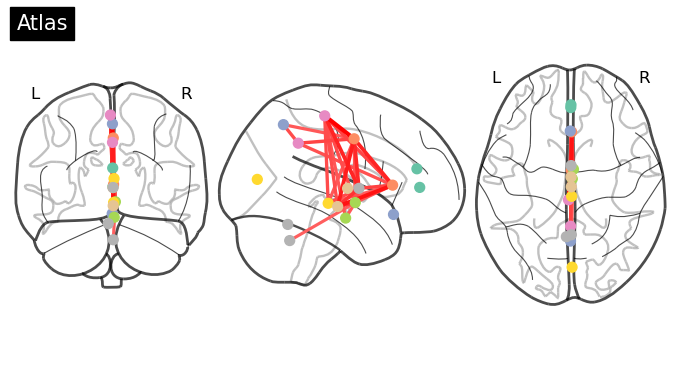

In [103]:
from nilearn import plotting

# Plot of the cortical atlas with connectome 
coordinates = plotting.find_parcellation_cut_coords(labels_img=atlas_filename)


# Get center of coordinates according to the brain_region_groups
coordinates_avg = []
for region in brain_region_groups.keys():
    indices = [labels.index(x) for x in brain_region_groups[region]]
    # take mean for each dimension
    avg_coord = np.mean(coordinates[indices, :], axis=0)
    coordinates_avg.append(avg_coord)


plotting.plot_connectome(
    agg_data_manual[0],
    coordinates_avg,
    edge_threshold="80%",
    title="Atlas",
)

In [ ]:
# Save data 
DATA_FOLDER_AGG = './comparison_data/ABIDE/manual/'
save_data(DATA_FOLDER_AGG, agg_data_manual, data_aal["label"])